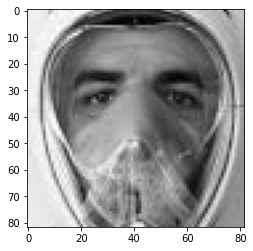

Epoch 1/5
294/294 [==============================] - 39s 134ms/step - loss: 0.5205 - accuracy: 0.7229 - val_loss: 0.1955 - val_accuracy: 0.9301
Epoch 2/5
294/294 [==============================] - 39s 132ms/step - loss: 0.2730 - accuracy: 0.8895 - val_loss: 0.0848 - val_accuracy: 0.9712
Epoch 3/5
294/294 [==============================] - 38s 130ms/step - loss: 0.1787 - accuracy: 0.9293 - val_loss: 0.0954 - val_accuracy: 0.9695
Epoch 4/5
294/294 [==============================] - 38s 130ms/step - loss: 0.1453 - accuracy: 0.9450 - val_loss: 0.1002 - val_accuracy: 0.9640
Epoch 5/5
294/294 [==============================] - 40s 137ms/step - loss: 0.1226 - accuracy: 0.9531 - val_loss: 0.0715 - val_accuracy: 0.9741


In [21]:
import pandas as pd
import numpy as np
import seaborn as sns
import os
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
import cv2
from scipy.spatial import distance
from sklearn.model_selection import train_test_split
import random
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import RMSprop,Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from sklearn.metrics import confusion_matrix
import itertools

from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import RMSprop,Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau

mask_path="C:\data\WithMask"
no_mask_path = "C:\data\WithoutMask"

for img in os.listdir(mask_path):
    img_array= cv2.imread(os.path.join(mask_path,img),cv2.IMREAD_GRAYSCALE)
    plt.imshow(img_array,cmap="gray")
    plt.show()
    break


IMG_SIZE = 82;

new_array =cv2.resize(img_array,(IMG_SIZE,IMG_SIZE))

training_data=[]



def create_training_data():
    class_num_1 = 0
    class_num_2 = 1
    
    for img in os.listdir(mask_path):
        try:
            img_array= cv2.imread(os.path.join(mask_path,img),cv2.IMREAD_GRAYSCALE) 
            new_array =cv2.resize(img_array,(IMG_SIZE,IMG_SIZE))
            training_data.append([new_array,class_num_1])
        except Exception as e:
            pass

    for img in os.listdir(no_mask_path):
        try:
            img_array= cv2.imread(os.path.join(no_mask_path,img),cv2.IMREAD_GRAYSCALE) 
            new_array =cv2.resize(img_array,(IMG_SIZE,IMG_SIZE))
            training_data.append([new_array,class_num_2])
        except Exception as e:
            pass
    

create_training_data()


random.shuffle(training_data)

X=[]
y=[]

for features, label in training_data:
    X.append(features)
    y.append(label)
    

X = np.array(X).reshape(-1,IMG_SIZE,IMG_SIZE,1) # one is because it is gray scale
y = np.array(y)

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation,Flatten


# Train-Test Split

x_train,x_test,y_train, y_test = train_test_split(X,y,test_size = 0.2,random_state=2)

x_train=x_train/255.0
x_test= x_test/255.0

model = Sequential()
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu', input_shape = x_train.shape[1:]))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Dropout(0.25))


model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(256,activation="relu"))


model.add(Dense(256,activation="relu"))


model.add(Dense(1))
model.add(Activation("sigmoid"))
model.compile(loss="binary_crossentropy",
              optimizer=Adam(lr=0.001),
              metrics=['accuracy'])    
epochs = 5
batch_size = 32

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # dimesion reduction
        rotation_range=5,  # randomly rotate images in the range 5 degrees
        zoom_range = 0.01, # Randomly zoom image 10%
        width_shift_range=0.1,  # randomly shift images horizontally 10%
        height_shift_range=0.1,  # randomly shift images vertically 10%
        horizontal_flip=True,  # randomly flip images
        vertical_flip=True)  # randomly flip images

datagen.fit(x_train)
#history = model.fit(x_train,y_train, batch_size=32,epochs=5,validation_split=0.1)
history = model.fit_generator(datagen.flow(x_train,y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (x_test,y_test), steps_per_epoch=x_train.shape[0] // batch_size)




In [45]:
y_pred=model.predict(x_test)
y_pred
y_pred.shape
for i in range(len(y_pred)):
    if y_pred[i]<0.5:
        y_pred[i]=0
    else:
        y_pred[i]=1

In [47]:
confusion_matrix(y_test,y_pred)


array([[1121,   43],
       [  18, 1177]], dtype=int64)

In [49]:
maskeli = cv2.imread("./2.jpg",cv2.IMREAD_GRAYSCALE)
type(maskeli)
maskeli = cv2.resize(maskeli,(82,82))
maskeli = np.array(maskeli).reshape(1,82,82,1)
maskeli = maskeli/255.0

#plt.imshow(maskeli)

a= model.predict(maskeli)
a

array([[0.9950094]], dtype=float32)